## Artificial Neural Network (ANN)
#### Import modules

In [17]:
# Import Modules and functions
# ----------------------------
from Functions import *
from Modules   import *

#### Import Tensorflow

In [18]:
from tensorflow.keras.models                import Sequential
from tensorflow.keras.layers                import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras                       import Sequential
from tensorflow.keras.layers                import Dense
from tensorflow.keras.utils                 import plot_model
from tensorflow.keras.callbacks             import EarlyStopping
from keras.metrics                          import Precision, Recall
from tensorflow.keras.layers                import Dropout

#### Read Dataframe

In [3]:
df    = pd.read_csv('..\\Data\\data_train.csv')
X_aim = pd.read_csv('..\\Data\\features_aim.csv')
# --- Clean and prepare data and Aim -----

X_train, X_test, y_train, y_test, X_aim            = CLEAN_All_DATA(df, X_aim)
X_train_copy, X_test_copy, X_aim_copy, cat_cols_FE = Kmeans_FE(X_train, X_test, X_aim, cat_cols)

#### Defining the ANN model #1

In [5]:

def create_model():
    model = Sequential([
                        Dense(512, activation='relu', input_shape=(2349,)),
                        Dense(512, activation='relu'),
                        Dense(512, activation='relu'),
                        Dense(512, activation='relu'),
                        Dense(512, activation='relu'),
                        Dense(512, activation='relu'),
                        Dense(512, activation='relu'),
                        Dense(1, activation='sigmoid')  
                       ])

    model.compile(loss      = 'binary_crossentropy',  
                  optimizer = 'adam',
                  metrics   = ['Recall']
                 )

    return model


#### Pipeline/ColumnTransformer

In [7]:

# --------------------------------------------------------------------------

num_pipeline = Pipeline([('poly'  , PolynomialFeatures(degree=2)),
                         ('scaler', StandardScaler()),
                         ('pca'   , PCA(n_components=.991))])

preprocessor = ColumnTransformer([('num', num_pipeline, num_cols),
                                  ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols_FE)])

ann1 = KerasClassifier(build_fn   = create_model, 
                       epochs      = 15, 
                       batch_size  = 64, 
                       #verbose     = False
                       )

pipeline_ann1 = Pipeline([('preprocessor', preprocessor),
                          ('ann'         , ann1)])

# --------------------------------------------------------------------------



C:\Users\josep\AppData\Local\Temp\ipykernel_6540\2828371964.py:10: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ann1 = KerasClassifier(build_fn   = create_model,


#### Fitting of ANN #1

In [8]:
pipeline_ann1.fit(X_train_copy, y_train)

Epoch 1/15
923/923 [==============================] - 39s 41ms/step - loss: 0.3181 - recall: 0.1860
Epoch 2/15
923/923 [==============================] - 37s 40ms/step - loss: 0.2907 - recall: 0.2413
Epoch 3/15
923/923 [==============================] - 39s 42ms/step - loss: 0.2759 - recall: 0.2706
Epoch 4/15
923/923 [==============================] - 42s 45ms/step - loss: 0.2548 - recall: 0.3154
Epoch 5/15
923/923 [==============================] - 45s 49ms/step - loss: 0.2252 - recall: 0.4248
Epoch 6/15
923/923 [==============================] - 47s 50ms/step - loss: 0.1882 - recall: 0.5456
Epoch 7/15
923/923 [==============================] - 45s 49ms/step - loss: 0.1512 - recall: 0.6562
Epoch 8/15
923/923 [==============================] - 47s 51ms/step - loss: 0.1185 - recall: 0.7539
Epoch 9/15
923/923 [==============================] - 46s 49ms/step - loss: 0.0958 - recall: 0.8010
Epoch 10/15
923/923 [==============================] - 47s 51ms/step - loss: 0.0754 - recall: 0.8544

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.991))]),
                                                  ['MMRAcquisitionAuctionAveragePrice',
                                                   'MMRAcquisitionAuctionCleanPrice',
                                                   'MMRAcquisitionRetailAveragePrice',
                                                   'MMRAcquisitonRetailCleanPrice',
                                                   'MMRCurrentAuctionAveragePrice',
                                                   '...
                                                  ['Auction', 'VehicleAge',
                                                   'Make', 'WheelType',
                                                   'VehYear', 'Model', 'Trim',
                                                   'SubModel', 'Color',
                                                   'Transmission',
                                                   'Nationality', 'Size',
                                                   'TopThreeAmericanName',
                                                   'IsOnlineSale', 'PRIMEUNIT',
                                                   'AUCGUART', 'BYRNO',
                                                   'VNZIP1', 'VNST',
                                                   'PurchDate_year',
                                                   'PurchDate_month',
                                                   'PurchDate_dayofweek',
                                                   'TransactionCluster'])])),
                ('ann',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x00000202388BEB90>)])

#### Scores and confusion matrix of ANN #1 

206/206 [==============================] - 1s 5ms/step
Scoring of ANN1 



Model,F1 Score,Recall,Precision,Accuracy
ANN1,0.366577,0.321513,0.426332,0.856751


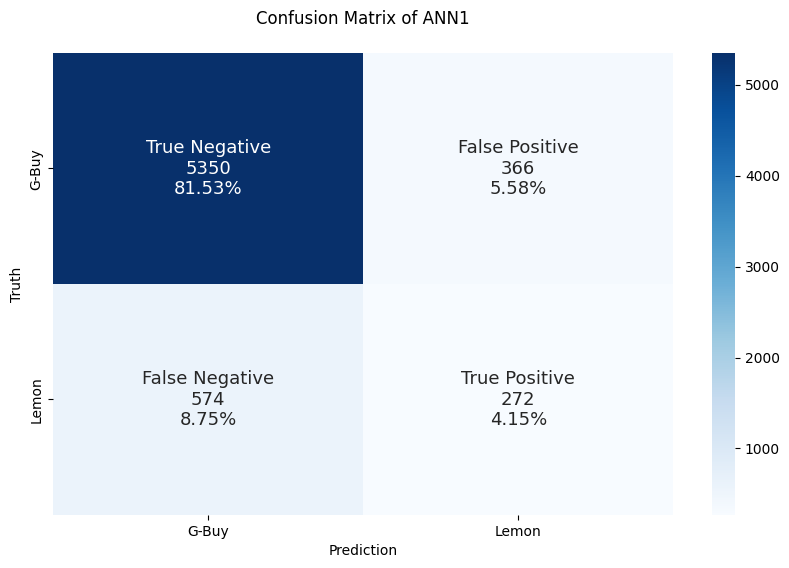

In [11]:
# Fit and scores 
predictions_ann1 = pipeline_ann1.predict(X_test_copy)
# -------------------------------------------------------

f1_ann1        = f1_score(y_test       , predictions_ann1)
recall_ann1    = recall_score(y_test   , predictions_ann1)
precision_ann1 = precision_score(y_test, predictions_ann1)
accuracy_ann1  = accuracy_score(y_test , predictions_ann1)

ann1_metrics     = pd.DataFrame({
                               'Model'    : ['ANN1'],
                               'F1 Score' : [f1_ann1],
                               'Recall'   : [recall_ann1],
                               'Precision': [precision_ann1],
                               'Accuracy' : [accuracy_ann1]
                               })

print('Scoring of ANN1 \n')
display(ann1_metrics.style.hide())
Confusion_Matrix_Func(y_test, predictions_ann1, 'ANN1');

#### Model: ANN #2

In [12]:

# Define the model
def create_model():
    model_ann_drop  = Sequential()
    hidden_first    = Dense(units=1024, activation='relu', input_shape=(2349,))
    hidden_second   = Dense(units=1024, activation='relu')
    hidden_third    = Dense(units=1024, activation='relu')
    hidden_fourth   = Dense(units=1024, activation='relu')
    hidden_fifth    = Dense(units=1024, activation='relu')
    
    #----------------------------------------------------
    dropout_layer_first  = Dropout(rate=0.3)
    dropout_layer_second = Dropout(rate=0.3)
    dropout_layer_third  = Dropout(rate=0.3)
    dropout_layer_fourth = Dropout(rate=0.3)
    dropout_layer_fifth  = Dropout(rate=0.3)
    
    output_layer    = Dense(1, activation='sigmoid') 
    
    model_ann_drop.add(hidden_first)
    model_ann_drop.add(dropout_layer_first)
    model_ann_drop.add(hidden_second)
    model_ann_drop.add(dropout_layer_second)
    model_ann_drop.add(hidden_third)
    model_ann_drop.add(dropout_layer_third)
    model_ann_drop.add(hidden_fourth)
    model_ann_drop.add(dropout_layer_fourth)
    model_ann_drop.add(hidden_fifth)
    model_ann_drop.add(dropout_layer_fifth)
    model_ann_drop.add(output_layer)
    

    model_ann_drop.compile(loss      = 'binary_crossentropy', 
                           optimizer = 'adam', 
                           metrics   = ['Recall'])
    
    return model_ann_drop

#### Pipeline of ANN #2

In [13]:

num_pipeline  = Pipeline([('poly'  , PolynomialFeatures(degree=2)),
                          ('scaler', StandardScaler()),
                          ('pca'   , PCA(n_components=.991))
                         ])

preprocessor  = ColumnTransformer([('num', num_pipeline, num_cols),
                                  ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols_FE)
                                  ])

early_stop    = EarlyStopping(monitor   = 'Recall', 
                              min_delta = 0.01, 
                              patience  = 2
                             )

ann2          = KerasClassifier(build_fn   = create_model, 
                                epochs     = 15, 
                                batch_size = 64, 
                                callbacks  = [early_stop], 
                                #verbose    = False
                                )

pipeline_ann2 = Pipeline([('preprocessor', preprocessor),
                          ('ann'         , ann2)
                         ])

C:\Users\josep\AppData\Local\Temp\ipykernel_6540\1953384984.py:15: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ann2          = KerasClassifier(build_fn   = create_model,


#### Fitting of ANN #2

In [14]:
pipeline_ann2.fit(X_train_copy, y_train)

Epoch 1/15
923/923 [==============================] - 102s 109ms/step - loss: 0.3284 - recall: 0.1580
Epoch 2/15
923/923 [==============================] - 103s 112ms/step - loss: 0.3001 - recall: 0.2272
Epoch 3/15
923/923 [==============================] - 113s 122ms/step - loss: 0.2871 - recall: 0.2385
Epoch 4/15
923/923 [==============================] - 106s 115ms/step - loss: 0.2748 - recall: 0.2593
Epoch 5/15
923/923 [==============================] - 91s 98ms/step - loss: 0.2584 - recall: 0.2972
Epoch 6/15
923/923 [==============================] - 80s 86ms/step - loss: 0.2388 - recall: 0.3495
Epoch 7/15
923/923 [==============================] - 71s 77ms/step - loss: 0.2155 - recall: 0.4281
Epoch 8/15
923/923 [==============================] - 71s 77ms/step - loss: 0.1945 - recall: 0.4977
Epoch 9/15
923/923 [==============================] - 70s 76ms/step - loss: 0.1731 - recall: 0.5686
Epoch 10/15
923/923 [==============================] - 67s 73ms/step - loss: 0.1526 - recall

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.991))]),
                                                  ['MMRAcquisitionAuctionAveragePrice',
                                                   'MMRAcquisitionAuctionCleanPrice',
                                                   'MMRAcquisitionRetailAveragePrice',
                                                   'MMRAcquisitonRetailCleanPrice',
                                                   'MMRCurrentAuctionAveragePrice',
                                                   '...
                                                  ['Auction', 'VehicleAge',
                                                   'Make', 'WheelType',
                                                   'VehYear', 'Model', 'Trim',
                                                   'SubModel', 'Color',
                                                   'Transmission',
                                                   'Nationality', 'Size',
                                                   'TopThreeAmericanName',
                                                   'IsOnlineSale', 'PRIMEUNIT',
                                                   'AUCGUART', 'BYRNO',
                                                   'VNZIP1', 'VNST',
                                                   'PurchDate_year',
                                                   'PurchDate_month',
                                                   'PurchDate_dayofweek',
                                                   'TransactionCluster'])])),
                ('ann',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x000002023BADB990>)])

#### Scores and confusion matrix of ANN #2

206/206 [==============================] - 2s 8ms/step
Scoring of ANN2 



Model,F1 Score,Recall,Precision,Accuracy
K-Nearest Neighbors,0.377329,0.287234,0.549774,0.877781


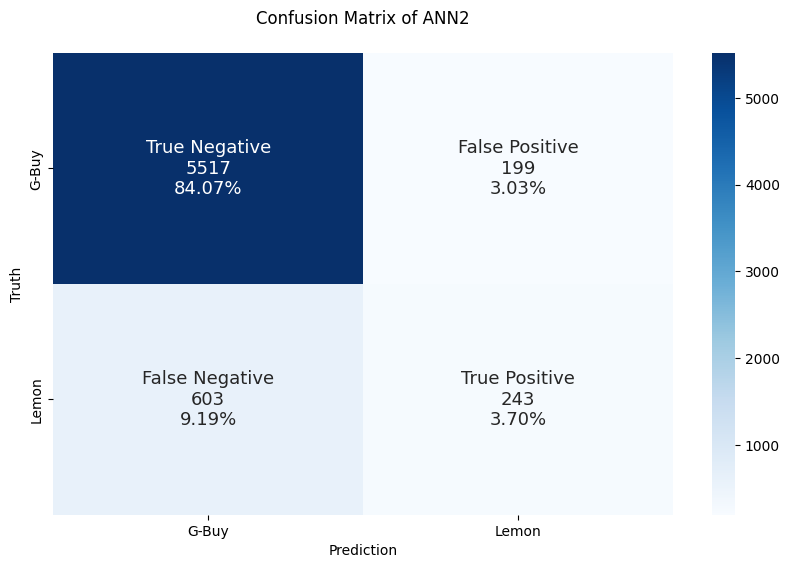

In [26]:


predictions_ann2 = pipeline_ann2.predict(X_test_copy)


f1_ann2          = f1_score(y_test, predictions_ann2)
recall_ann2      = recall_score(y_test, predictions_ann2)
accuracy_ann2    = accuracy_score(y_test, predictions_ann2)
precision_ann2   = precision_score(y_test, predictions_ann2)

ann2_metrics     = pd.DataFrame({
                               'Model'    : ['K-Nearest Neighbors'],
                               'F1 Score' : [f1_ann2],
                               'Recall'   : [recall_ann2],
                               'Precision': [precision_ann2],
                               'Accuracy' : [accuracy_ann2]
                            })

print('Scoring of ANN2 \n')
display(ann2_metrics.style.hide())
Confusion_Matrix_Func(y_test, predictions_ann2, 'ANN2');